<a href="https://colab.research.google.com/github/Azaidi317/Segmentation-SAM/blob/main/Segment_SAM_auto_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-o1tfzdo3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-o1tfzdo3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=862cf3064c0a4f5ac3247289c7a3113004d4baeee89be84530fbffb098854148
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkyw5lvg/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-11-27 09:32:25--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.22

Loading SAM model...


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Please upload your image...
Upload an image...


Saving human+dog.jpeg to human+dog.jpeg
Generating automatic segmentation masks...
Displaying results...


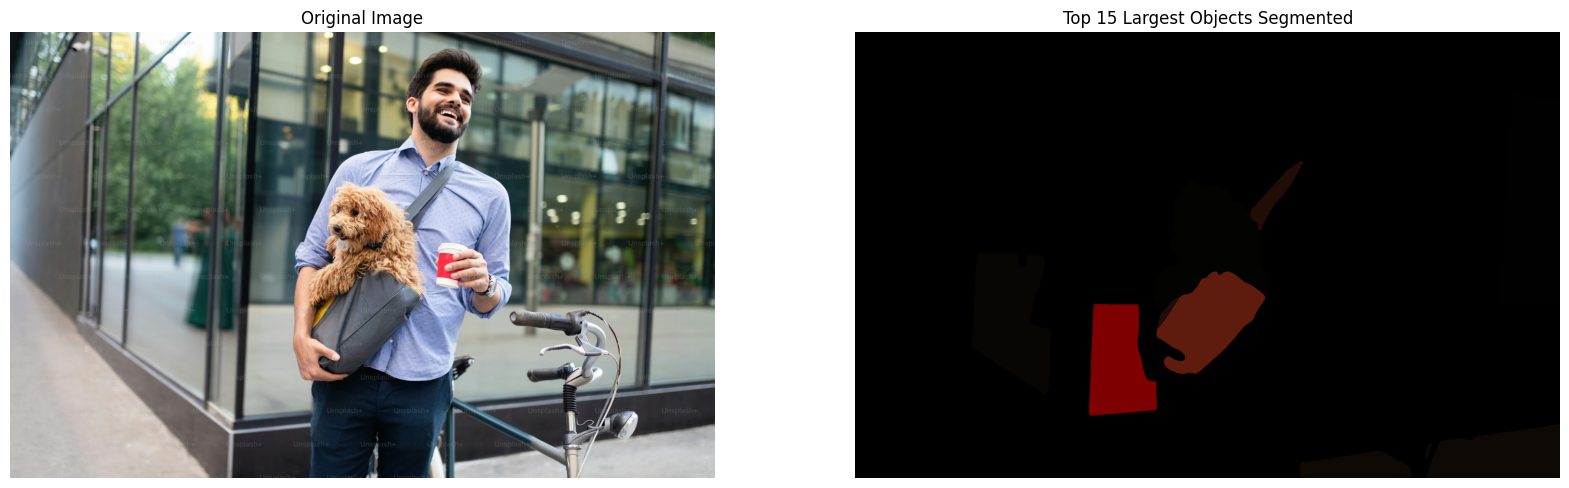


Top 15 largest objects detected:
Object 1: Area = 3745041 pixels, Confidence = 0.987
Object 2: Area = 536642 pixels, Confidence = 1.003
Object 3: Area = 402493 pixels, Confidence = 1.019
Object 4: Area = 346087 pixels, Confidence = 1.012
Object 5: Area = 304592 pixels, Confidence = 0.971
Object 6: Area = 273858 pixels, Confidence = 1.002
Object 7: Area = 231730 pixels, Confidence = 1.014
Object 8: Area = 211249 pixels, Confidence = 0.945
Object 9: Area = 201834 pixels, Confidence = 0.995
Object 10: Area = 149403 pixels, Confidence = 0.994
Object 11: Area = 145868 pixels, Confidence = 0.985
Object 12: Area = 145220 pixels, Confidence = 1.000
Object 13: Area = 136542 pixels, Confidence = 0.991
Object 14: Area = 115646 pixels, Confidence = 0.990
Object 15: Area = 106059 pixels, Confidence = 0.998


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from google.colab import files

def load_sam():
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    MODEL_TYPE = "vit_h"
    CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
    sam.to(device=DEVICE)

    # Adjusted parameters for fewer, more significant objects
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16,          # Reduced from 32
        pred_iou_thresh=0.92,        # Increased from 0.86
        stability_score_thresh=0.96,  # Increased from 0.92
        min_mask_region_area=1000,   # Increased from 100
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        output_mode="binary_mask"    # Simplified output mode
    )
    return mask_generator

def upload_and_load_image():
    print("Upload an image...")
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_anns(masks, image):
    if len(masks) == 0:
        return

    # Sort masks by area (largest first)
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

    # Take only the top 5 largest masks
    top_masks = sorted_masks[:15]

    # Generate distinct colors for visualization
    colors = plt.cm.rainbow(np.linspace(0, 1, len(top_masks)))[:, :3]

    plt.figure(figsize=(20, 10))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Show segmented image
    plt.subplot(1, 2, 2)
    plt.imshow(image)

    # Plot each mask
    for i, ann in enumerate(top_masks):
        m = ann['segmentation']
        color_mask = np.zeros((m.shape[0], m.shape[1], 3))
        color_mask[m] = colors[i]
        plt.imshow(color_mask, alpha=0.5)

    plt.title(f"Top {len(top_masks)} Largest Objects Segmented")
    plt.axis('off')
    plt.show()

    # Print information about detected objects
    print(f"\nTop {len(top_masks)} largest objects detected:")
    for i, mask in enumerate(top_masks):
        print(f"Object {i+1}: Area = {mask['area']:.0f} pixels, Confidence = {mask['predicted_iou']:.3f}")

# Main execution
print("Loading SAM model...")
mask_generator = load_sam()

print("Please upload your image...")
image = upload_and_load_image()

print("Generating automatic segmentation masks...")
masks = mask_generator.generate(image)

print("Displaying results...")
show_anns(masks, image)